# Set up environment variables, constants, and imports

In [1]:
# NOTE - Set the following environment variables to the correct paths for your system if they aren't already set.
import os
# os.environ.setdefault('RESULTS_FOLDER', '/PATH/TO/YOUR/nnUNet_models')
# os.environ.setdefault('nnUNet_preprocessed', '/PATH/TO/YOUR/nnUNet_preprocessed')
# os.environ.setdefault('nnUNet_raw_data_base', '/PATH/TO/YOUR/nnUNet_raw')

'/mnt/Bunker/nnUNet_Bunker/nnUNet_raw'

In [2]:
import functools

import numpy as np
import SimpleITK as sitk  # Extra for handling nifti files in this example
import torch
import matplotlib.pyplot as plt

import attribution_quality as attq
from attribution_quality.nnunet_utils import get_sample_path, get_trainer, OutputMuffle, prep_data
from attribution_quality.splitnet.split_nnunet import decompose_nnunet

TASK_ID = 902
SAMPLE_ID = 'nodule_199'
SAMPLE_SLICE = (82, slice(None), slice(None))  # Spatial slice to use for visualization
CAM_TYPES = [attq.KWC, attq.GradCAM, attq.GradCAMPlusPlus, attq.ScoreCAM]
TARGET_LAYER_NUM = 1



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



# Load Data and Models

In [3]:
"""
This code is specific to loading nnUNet models and data. For other frameworks, you just need to load your model and define the target layer as a string. See `attribution_quality.utils.getattr_recursive` for more details on formatting the target layer string.

In this example, the target layer is `conv_blocks_context.0.blocks.1.conv`, which is equivalent to the python code `model.conv_blocks_context[0].blocks[1].conv`, with each parameter separated by a period and indexing represented with integers.
"""
with OutputMuffle('stdout') as f:  # nnunet can be very verbose when loading/preprocessing data and models
    trainer = get_trainer(task=TASK_ID)
    model = trainer.network
    data, slicer = prep_data(trainer, SAMPLE_ID)

# Note - Labels are just for visualization in this notebook, not used in attribution
_, label_path = get_sample_path(902, SAMPLE_ID)
label = sitk.ReadImage(label_path[0])
label = sitk.GetArrayFromImage(label)
label_slice = label[SAMPLE_SLICE]
feat_label = sitk.ReadImage(label_path[0].replace('labelsTs', 'labelsTs_full'))
feat_label = sitk.GetArrayFromImage(feat_label)
feat_label_slice = feat_label[SAMPLE_SLICE]

# NOTE - We ignore bottleneck layers in this example as their activation maps' spatial resolution is generally too low to be meaningful.
encoder_layers, bottleneck_layers, decoder_layers, skip_connections = decompose_nnunet(model, names_only=True)
if TARGET_LAYER_NUM < len(encoder_layers):
    target_layer = encoder_layers[TARGET_LAYER_NUM]
else:
    target_layer = decoder_layers[TARGET_LAYER_NUM - len(encoder_layers)]    
print(target_layer)

conv_blocks_context.0.blocks.1.conv


# Generate Attribution Maps for a Single Layer

In [4]:
"""
Activation function defaults to identity, but can be set by: 
    1) Passing a function to the `activation_func` argument of the constructor for any CAM wrapper
    2) Setting the `activation_func` parameter of the wrapped CAM model
    3) Passing a function to the `activation_func` argument of the `forward` method of the wrapped CAM model (overwrites 1 and 2)
    
This is needed, as nnunet keeps the output activation separate from the model, but some CAM methods operate using post-activation outputs
"""
activation_function = functools.partial(torch.nn.functional.softmax, dim=1)

# NOTE - The `cam_model` will automatically handle converting numpy arrays to torch tensors and also to cuda if `use_cuda=True`
cam_slices = []
for idx, cam_method in enumerate(CAM_TYPES):
    with cam_method(model, target_layer, activation_func=activation_function) as cam_model:
        cam = cam_model.forward(data[None])[0]
        cam_slices.append(np.squeeze(cam)[SAMPLE_SLICE])  # Extracting a slice for visualization

# Visualize the Results

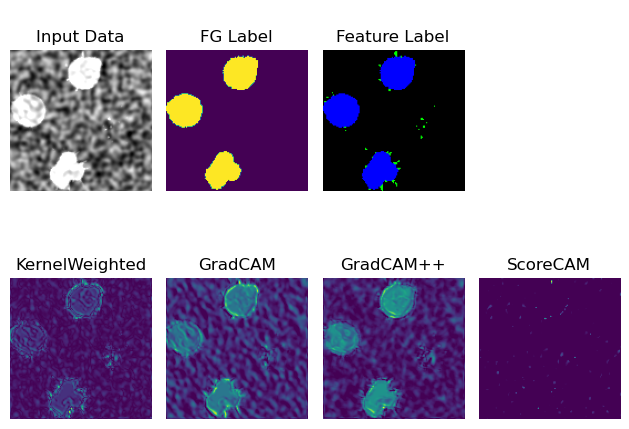

'\nNote - Because the target layer is close to the beginning of the model, the gradient-based CAMs may be unreliable.\n'

In [5]:
%matplotlib inline
data_slice = np.squeeze(data)[SAMPLE_SLICE]

fig, axes = plt.subplots(nrows=2, ncols=len(CAM_TYPES))
for ax in axes.ravel():
    ax.axis('off')
    

axes[0, 0].imshow(data_slice, cmap='gray')
axes[0, 0].set_title('Input Data')

axes[0, 1].imshow(label_slice)
axes[0, 1].set_title('FG Label')

feat_label_slice_color = np.zeros(list(feat_label_slice.shape) + [3], dtype=np.uint8)
feat_label_slice_color[feat_label_slice == 1] = [255, 0, 0]  # Red = False Positive Background ("normal" nodules)
feat_label_slice_color[feat_label_slice == 2] = [0, 255, 0]  # Blue = True Positive Foreground (spiculated nodules)
feat_label_slice_color[feat_label_slice == 3] = [0, 0, 255]  # Green = Discriminating Background (nodule spiculations)
axes[0, 2].imshow(feat_label_slice_color)
axes[0, 2].set_title('Feature Label')

for idx in range(len(cam_slices)):
    axes[1, idx].imshow(cam_slices[idx], cmap='viridis')
    axes[1, idx].set_title(CAM_TYPES[idx].name)
plt.tight_layout()
plt.show()

"""
Note - Because the target layer is close to the beginning of the model, the gradient-based CAMs may be unreliable.
"""